In [1]:
%pylab inline
import h5py

Populating the interactive namespace from numpy and matplotlib


In [2]:
f_train = h5py.File('train.h5','r')
f_test = h5py.File('test.h5','r')

In [3]:
print(f_train.keys())
print(f_test.keys())

[u'train']
[u'test']


In [4]:
a_train = f_train['train']
a_test = f_test['test']

In [5]:
print(a_train.keys())
print(a_test.keys())

[u'axis0', u'axis1', u'block0_items', u'block0_values', u'block1_items', u'block1_values']
[u'axis0', u'axis1', u'block0_items', u'block0_values']


In [6]:
b = a_test['block0_values']

In [7]:
b.shape

(8137, 100)

In [8]:
# axis0 -> Labels [shape (101,)]
# axis1 -> id column [shape (45324,)]
# block0_items -> traits labels [shape (100,)]
# block0_values -> traits values [shape (45324,100)]
# block1_items -> 'y' label
# block1_values -> y column (without label) [shape (45324,1)]

In [47]:
X_train = a_train['block0_values'][()]
y_train = a_train['block1_values'][()]
y_train = y_train[:,0]
X_test = a_test['block0_values'][()]
X_train, X_val = X_train[:-8324], X_train[-8324:]
y_train, y_val = y_train[:-8324], y_train[-8324:]

In [37]:
print(X_train.shape)
print(type(X_train))

(37000, 100)
<type 'numpy.ndarray'>


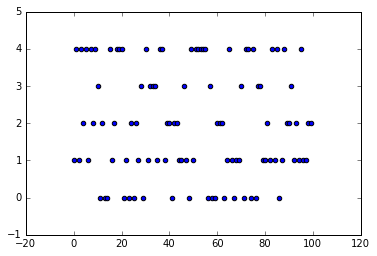

In [48]:
scatter(arange(100), y_train[0:100])

In [15]:
s = ''
z = 0
for i in arange(100):
    for j in arange(100):
        if b[i,j]==0.:
            z=z+1
        s += str(b[i,j]) + ' '
    s += '/n'

In [16]:
print(str(z/100.) + '% percentage of zeros in chunk of matrix')

78.1% percentage of zeros in chunk of matrix


In [17]:
from theano import *
import theano.tensor as T

In [12]:
x = T.dvector('x') # declare variable
y = T.dvector('y')
out = y.dot(y) + x.dot(x)         # build symbolic expression
fun = theano.function([x,y], out)   # compile function
print(fun([2,1],[1,1]))

7.0


# Neural Network: Lasagne

In [18]:
from __future__ import print_function
import time
import lasagne

/Users/Camilo/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [49]:
def build_custom_mlp(input_var=None, depth=2, width=800, drop_input=.2,
                     drop_hidden=.5):
    # By default, this creates the same network as `build_mlp`, but it can be
    # customized with respect to the number and size of hidden layers. This
    # mostly showcases how creating a network in Python code can be a lot more
    # flexible than a configuration file. Note that to make the code easier,
    # all the layers are just called `network` -- there is no need to give them
    # different names if all we return is the last one we created anyway; we
    # just used different names above for clarity.

    # Input layer and dropout (with shortcut `dropout` for `DropoutLayer`):
    network = lasagne.layers.InputLayer(shape=(None, 100),
                                        input_var=input_var)
    if drop_input:
        network = lasagne.layers.dropout(network, p=drop_input)
    # Hidden layers and dropout:
    nonlin = lasagne.nonlinearities.rectify
    for _ in range(depth):
        network = lasagne.layers.DenseLayer(network, width, nonlinearity=nonlin)
        if drop_hidden:
            network = lasagne.layers.dropout(network, p=drop_hidden)
    # Output layer:
    softmax = lasagne.nonlinearities.softmax
    network = lasagne.layers.DenseLayer(network, 5, nonlinearity=softmax)
    return network

In [50]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [93]:
def train(num_epochs=500):
    # Load the dataset
    # print("Loading data...")
    # X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
    
    # theano.config.optimizer='fast_compile'
    # theano.config.exception_verbosity='high'

    # Prepare Theano variables for inputs and targets
    input_var = T.matrix('inputs')
    target_var = T.ivector('targets')

    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")
    
    network = build_custom_mlp(input_var=input_var)

    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    global prediction
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    global params
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01, momentum=0.9)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    global test_prediction
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,target_var)
    test_loss = test_loss.mean()
    
    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates, allow_input_downcast=True)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc], allow_input_downcast=True)

    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        
        for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 500, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))

    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, zeros(len(X_test)), 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))
    global result
    result = lasagne.layers.get_output(network, X_test)

In [108]:
train(num_epochs=10)

Building model and compiling functions...
Starting training...
Epoch 1 of 10 took 7.961s
  training loss:		1.271109
  validation loss:		0.800002
  validation accuracy:		73.99 %
Epoch 2 of 10 took 7.829s
  training loss:		0.862463
  validation loss:		0.626833
  validation accuracy:		78.47 %
Epoch 3 of 10 took 7.847s
  training loss:		0.769628
  validation loss:		0.559716
  validation accuracy:		80.61 %
Epoch 4 of 10 took 7.993s
  training loss:		0.708806
  validation loss:		0.514491
  validation accuracy:		82.69 %
Epoch 5 of 10 took 7.867s
  training loss:		0.669824
  validation loss:		0.479372
  validation accuracy:		84.19 %
Epoch 6 of 10 took 7.838s
  training loss:		0.629248
  validation loss:		0.444861
  validation accuracy:		85.52 %
Epoch 7 of 10 took 7.865s
  training loss:		0.602473
  validation loss:		0.423070
  validation accuracy:		86.40 %
Epoch 8 of 10 took 7.893s
  training loss:		0.578431
  validation loss:		0.400502
  validation accuracy:		87.02 %
Epoch 9 of 10 took 8.485s

In [113]:
final = result.eval()
final

array([[  5.50124294e-02,   4.87319617e-02,   3.62583785e-02,
          1.60178457e-01,   6.99818774e-01],
       [  1.61181905e-02,   1.40533871e-03,   4.23213505e-01,
          2.55160790e-01,   3.04102176e-01],
       [  3.23989469e-01,   6.07254414e-02,   1.56731097e-02,
          1.81347875e-01,   4.18264105e-01],
       ..., 
       [  9.87987196e-01,   2.24993996e-03,   3.06034903e-03,
          6.38861710e-03,   3.13898410e-04],
       [  9.34480076e-01,   2.02446452e-03,   2.01833231e-02,
          2.53259230e-02,   1.79862138e-02],
       [  2.99844557e-02,   6.36540826e-03,   7.92438084e-01,
          4.85413042e-02,   1.22670748e-01]])

In [114]:
sum(final[0,:])

0.99999999999999989

In [127]:
y_output = list([])
for i in arange(len(final)):
    my_list = final[i,:]
    max_index = my_list.argmax()
    y_output.append(max_index)

In [128]:
len(y_output)

8137

In [129]:
y_output

[4,
 2,
 4,
 3,
 1,
 0,
 3,
 4,
 3,
 1,
 1,
 1,
 3,
 3,
 2,
 1,
 2,
 3,
 0,
 1,
 0,
 4,
 0,
 2,
 4,
 0,
 4,
 4,
 0,
 4,
 1,
 2,
 2,
 3,
 4,
 4,
 3,
 0,
 3,
 4,
 2,
 2,
 3,
 3,
 4,
 2,
 0,
 0,
 2,
 3,
 1,
 2,
 1,
 1,
 0,
 4,
 3,
 0,
 3,
 4,
 2,
 0,
 0,
 0,
 3,
 0,
 2,
 0,
 1,
 0,
 0,
 3,
 1,
 3,
 4,
 3,
 3,
 1,
 2,
 3,
 1,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 3,
 2,
 1,
 3,
 0,
 4,
 3,
 3,
 0,
 2,
 1,
 1,
 2,
 2,
 3,
 0,
 0,
 0,
 0,
 1,
 4,
 3,
 2,
 2,
 4,
 3,
 2,
 3,
 3,
 2,
 0,
 1,
 0,
 1,
 1,
 2,
 4,
 4,
 1,
 1,
 0,
 2,
 4,
 4,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 0,
 3,
 2,
 3,
 4,
 1,
 2,
 1,
 0,
 1,
 1,
 3,
 0,
 3,
 3,
 2,
 1,
 0,
 0,
 0,
 1,
 3,
 0,
 0,
 2,
 1,
 0,
 4,
 0,
 0,
 1,
 3,
 2,
 4,
 0,
 3,
 4,
 1,
 4,
 4,
 2,
 0,
 3,
 0,
 1,
 2,
 4,
 1,
 3,
 1,
 2,
 3,
 0,
 4,
 0,
 3,
 4,
 1,
 4,
 2,
 1,
 3,
 2,
 0,
 3,
 2,
 3,
 2,
 2,
 1,
 2,
 1,
 3,
 4,
 1,
 3,
 0,
 3,
 2,
 0,
 3,
 2,
 4,
 1,
 2,
 4,
 2,
 1,
 2,
 2,
 4,
 2,
 2,
 3,
 1,
 0,
 4,
 1,
 2,
 1,
 2,
 3,
 2,
 0,
 0,
 4,
 3,
 0,
 0,
 0,
